#IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional
from sklearn.neighbors import KNeighborsClassifier

#LOADING THE DATASETS

In [ ]:
labels=['Tweet_ID','Entity','Sentiment','Tweet_content']
training_df=pd.read_csv("/content/twitter_training.csv", names=labels)

#EDA

In [ ]:
training_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


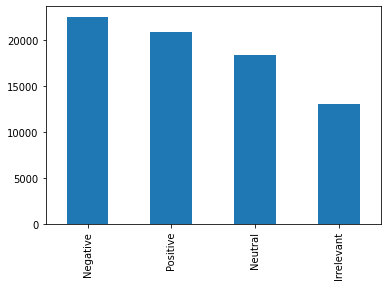

In [ ]:
training_df["Sentiment"].value_counts().plot(kind="bar")

In [ ]:
training_df.isna().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [ ]:
training_df["Tweet_content"].isna().sum()

686

In [ ]:
training_df.dropna(inplace=True)

In [ ]:
training_df.isna().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

In [ ]:
training_df.duplicated().sum()

2340

In [ ]:
training_df.drop_duplicates(inplace=True)

In [ ]:
training_df.duplicated().sum()

0

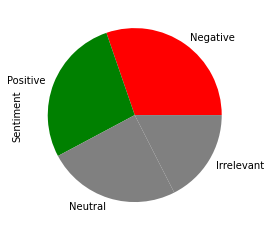

In [ ]:
training_df["Sentiment"].value_counts().plot(kind='pie', colors=['Red', 'Green','Gray', 'Gray'])

#PRE-PROCESSING

One-Hot Encoding for the Sentiment column

In [ ]:
training_df["Sentiment"]=LabelEncoder().fit_transform(training_df["Sentiment"])
training_df["Sentiment"]

0        3
1        3
2        3
3        3
4        3
        ..
74677    3
74678    3
74679    3
74680    3
74681    3
Name: Sentiment, Length: 73996, dtype: int64

Splitting the dataset into various parts for easier access

In [ ]:
training_tweets=training_df["Tweet_content"]
training_sentiments_of_tweets=training_df["Sentiment"]

Removing User Tags, HashTags, URLs from tweets

In [ ]:
def remove_tags_hashtags_links(tweet):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(pic.twitter.com\S+)|(\w+:\/\/\S+)|(http\S+)"," ",tweet).split())

training_tweets=[remove_tags_hashtags_links(tweet) for tweet in training_tweets]

In [ ]:
training_tweets[:10]

['im getting on borderlands and i will murder you all',
 'I am coming to the borders and I will kill you all',
 'im getting on borderlands and i will kill you all',
 'im coming on borderlands and i will murder you all',
 'im getting on borderlands 2 and i will murder you me all',
 'im getting into borderlands and i can murder you all',
 'So I spent a few hours making something for fun If you don t know I am a HUGE fan and Maya is one of my favorite characters So I decided to make myself a wallpaper for my PC Here is the original image versus the creation I made Enjoy',
 'So I spent a couple of hours doing something for fun If you don t know that I m a huge Borderlands fan and Maya is one of my favorite characters I decided to make a wallpaper for my PC Here s the original picture compared to the creation I made Have fun pic twitter com mLsI5wf9Jg',
 'So I spent a few hours doing something for fun If you don t know I m a HUGE Borderlands fan and Maya is one of my favorite characters',
 

Stop word removal

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words=stopwords.words("english")
def remove_stop_words_from_tweets(tweet):
  return " ".join([word for word in tweet.split(sep=" ") if word not in stop_words])
training_tweets=[remove_stop_words_from_tweets(tweet) for tweet in training_tweets]

In [ ]:
training_tweets[:10]

['im getting borderlands murder',
 'I coming borders I kill',
 'im getting borderlands kill',
 'im coming borderlands murder',
 'im getting borderlands 2 murder',
 'im getting borderlands murder',
 'So I spent hours making something fun If know I HUGE fan Maya one favorite characters So I decided make wallpaper PC Here original image versus creation I made Enjoy',
 'So I spent couple hours something fun If know I huge Borderlands fan Maya one favorite characters I decided make wallpaper PC Here original picture compared creation I made Have fun pic twitter com mLsI5wf9Jg',
 'So I spent hours something fun If know I HUGE Borderlands fan Maya one favorite characters',
 'So I spent hours making something fun If know I HUGE RhandlerR fan Maya one favorite characters So I decided make wallpaper PC Here original image versus creation I made Enjoy']

Stemming the words

In [ ]:
def stem_the_word(tweet):
  return " ".join([PorterStemmer().stem(word) for word in tweet.split(sep=' ')])
training_tweets=[stem_the_word(tweet) for tweet in training_tweets]

In [ ]:
training_tweets[:10]

<10x23571 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in Compressed Sparse Row format>

TF-IDF Vectorization

In [ ]:
tfidf=TfidfVectorizer()
tf_idf_training_tweets=tfidf.fit_transform(training_tweets)

Split the data

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(tf_idf_training_tweets, training_sentiments_of_tweets, train_size=0.75)

#MODELS

Random Forest Classifier

In [ ]:
text_classifier=RandomForestClassifier(n_estimators=500, random_state=0)
text_classifier.fit(X_train, y_train)
y_pred=text_classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      3179
           1       0.91      0.94      0.93      5376
           2       0.95      0.90      0.92      4462
           3       0.86      0.94      0.90      4897

    accuracy                           0.91     17914
   macro avg       0.92      0.91      0.91     17914
weighted avg       0.92      0.91      0.91     17914



Logistic Regression

In [ ]:
lr_classifier = LogisticRegression(random_state = 0)
lr_classifier.fit(X_train, y_train)
y_pred = lr_classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67      3179
           1       0.72      0.83      0.77      5376
           2       0.77      0.70      0.73      4462
           3       0.74      0.77      0.75      4897

    accuracy                           0.74     17914
   macro avg       0.75      0.72      0.73     17914
weighted avg       0.74      0.74      0.74     17914



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LSTM

Tokenizing the data

In [ ]:
tokenizer = Tokenizer(num_words=8000, split=' ') 
tokenizer.fit_on_texts(training_tweets)
X = tokenizer.texts_to_sequences(training_tweets)
X = pad_sequences(X, maxlen=300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,training_sentiments_of_tweets, train_size = 0.8)

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 8000, output_dim = 128, input_length = 300))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model_lstm.summary())

model_lstm.fit(X_train, y_train, epochs=10, batch_size=512, verbose='auto')
model_lstm.evaluate(X_test,y_test)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 128)          1024000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 300, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 645       
                                                      

[0.5287145376205444, 0.8160811066627502]

Bi-Directional LSTM

It maximizes the order sensitivity of the RNNs: essentially it consists of two RNNs (LSTMs or GRUs) that process the input sequence in one different direction to finally merge representations. By doing this, they’re able to catch more complex patterns than a single RNN layer would catch. In other words, one of the layers interprets the sequences in chronological order and the second one do so in anti-chronological order, that’s why Bidirectional RNNs are widely used, because they offer greater performance than regular RNNs.

In [ ]:
bid_lstm = Sequential()
bid_lstm.add(Embedding(input_dim=8000, output_dim=128, input_length=300))
bid_lstm.add(Bidirectional(LSTM(128,dropout=0.3)))
bid_lstm.add(Dense(128, activation = 'relu'))
bid_lstm.add(Dropout(0.3))
bid_lstm.add(Dense(5, activation = 'softmax'))
bid_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(bid_lstm.summary())

bid_lstm.fit(X_train, y_train, epochs=10, batch_size=512, verbose='auto')
bid_lstm.evaluate(X_test,y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1024000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1,320,709
Trainable params: 1,320,709
Non-trainable params: 0
______________________________________________

[0.5442230105400085, 0.8201351165771484]

KNN

In [ ]:
import numpy as np 
import pandas as pd

import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import warnings
warnings.filterwarnings("ignore")

labels = ["Twitter_ID","Entity","Sentiment","Tweet_content"]
data = pd.read_csv("/content/twitter_training.csv",names=labels,header=None)

training_df = data[["Tweet_content","Sentiment"]]
training_df= training_df.drop_duplicates()

sentiment = []

for i in training_df["Sentiment"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
training_df["Sentiment"] = sentiment

stop_words = set(stopwords.words("english"))
training_df["Tweet_content"] = training_df["Tweet_content"].str.replace("\d","")

import nltk
nltk.download('omw-1.4')

def cleaner(data):

    tokens = word_tokenize(str(data).replace("'", "").lower()) 
    without_punc = [w for w in tokens if w.isalpha()]
    without_sw = [t for t in without_punc if t not in stop_words]
    Tweet_content_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    Tweet_content_cleaned = [PorterStemmer().stem(w) for w in Tweet_content_len]
    return " ".join(Tweet_content_cleaned)

training_df["Tweet_content"] = training_df["Tweet_content"].apply(cleaner)
training_df["Tweet_content"].head()

training_df["Tweet_content"]=training_df["Tweet_content"].str.replace("im","")
training_df["Tweet_content"].head()

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

X = training_df["Tweet_content"]
y = training_df["Sentiment"]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42,stratify = y)

from sklearn.feature_extraction.text import CountVectorizer

vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train_count,y_train)

knn_pred = knn_model.predict(X_test_count)


print(classification_report(y_test,knn_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


              precision    recall  f1-score   support

          -1       0.81      0.87      0.84      6371
           0       0.86      0.81      0.84      8819
           1       0.81      0.81      0.81      5742

    accuracy                           0.83     20932
   macro avg       0.83      0.83      0.83     20932
weighted avg       0.83      0.83      0.83     20932

